In [62]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Устанавливаем глобальные параметры
plt.rc('image', cmap='gray')
random.seed(0)
np.random.seed(0)

In [63]:
# Загружаем тренировочные и тестовые данные
train_labels = np.genfromtxt('./dataset/mnist_train.csv',
                             delimiter=',',
                             usecols=[0],
                             dtype=int)
train_images = np.genfromtxt('./dataset/mnist_train.csv',
                             delimiter=',',
                             usecols=list(range(1, 28 * 28 + 1)))
test_labels = np.genfromtxt('./dataset/mnist_test.csv',
                            delimiter=',',
                            usecols=[0],
                            dtype=int)
test_images = np.genfromtxt('./dataset/mnist_test.csv',
                            delimiter=',',
                            usecols=list(range(1, 28 * 28 + 1)))
train = (train_images, train_labels)
test = (test_images, test_labels)

In [64]:
def data_visualisation(data):
    cols, rows = 10, 2
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4))
    for col in range(cols):
        for row in range(rows):
            idx = random.randint(0, len(data[0]))
            image = data[0][idx].reshape(28, 28)
            label = data[1][idx]
            axes[row][col].imshow(image)
            axes[row][col].set_title(f"Label: {label}")
            axes[row][col].get_xaxis().set_visible(False)
            axes[row][col].get_yaxis().set_visible(False)

In [65]:
def result_visualisation(model, test_data):
    cols, rows = 10, 2
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 4))
    for col in range(cols):
        for row in range(rows):
            idx = random.randint(0, len(test_data[0]))
            image = test_data[0][idx].reshape(28, 28)
            label = test_data[1][idx]
            prediction = model.forward(test_data[0][idx] / 255)
            axes[row][col].imshow(image)
            axes[row][col].set_title(
                f"Label: {label}\n"
                f"Prediction: {np.argmax(prediction, axis=1)[0]}")
            axes[row][col].get_xaxis().set_visible(False)
            axes[row][col].get_yaxis().set_visible(False)

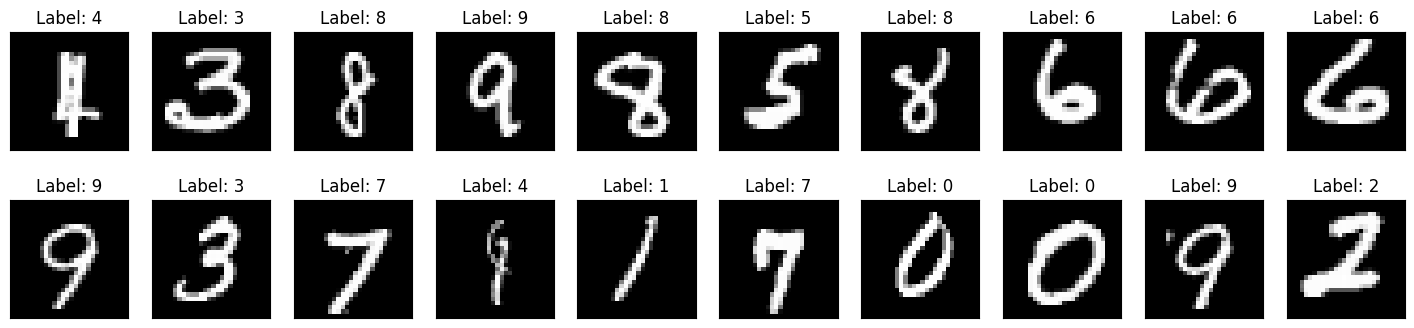

In [66]:
# Визуализация тренировочных данных
data_visualisation(train)

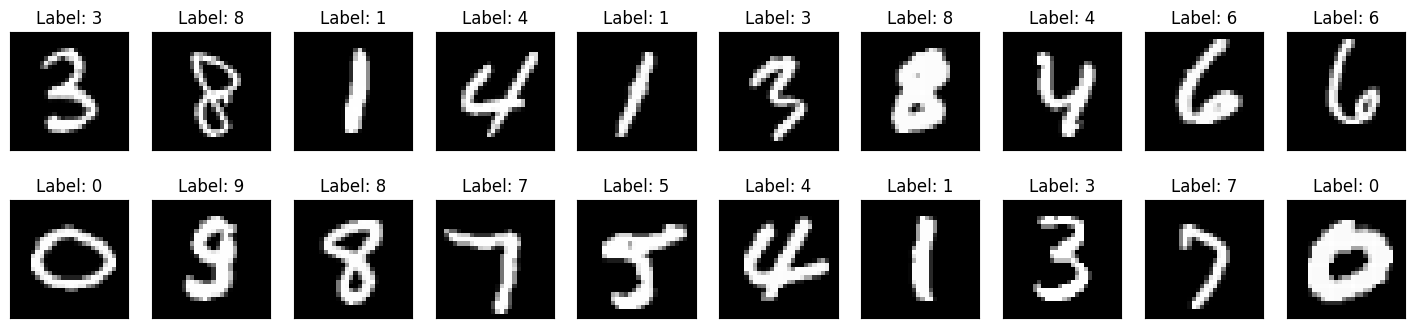

In [67]:
# Визуализация тестовых данных
data_visualisation(test)

In [68]:
# Параметры сети
input_size = 28 * 28
hidden_size = 300
output_size = 10

In [69]:
# Параметры обучения
learning_rate = 0.1
epochs = 20
batch_size = 40

In [70]:
# Нормализация изображений
train_images = train_images / 255
test_images = test_images / 255

# Преобразование меток в формат one-hot
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

In [71]:
class FCNetwork:

    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Инициализация весов (Uniform Xavier Initialization)
        s1 = np.sqrt(6 / (input_size + hidden_size))
        s2 = np.sqrt(6 / (hidden_size + output_size))
        self.W1 = np.random.uniform(-s1, s1, [input_size, hidden_size])
        self.W2 = np.random.uniform(-s2, s2, [hidden_size, output_size])
        self.b1 = np.zeros((1, hidden_size))
        self.b2 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def layer(self, X, W, B):
        return np.dot(X, W) + B

    def SGD(self, l, dl):
        l -= self.learning_rate * dl

    def forward(self, x):
        self.z1 = self.layer(x, self.W1, self.b1)
        self.a1 = self.relu(self.z1)
        self.z2 = self.layer(self.a1, self.W2, self.b2)
        y_pred = self.softmax(self.z2)
        return y_pred

    def backward(self, X, y):
        m = X.shape[0]
        y_pred = self.forward(X)
        dz2 = (y_pred - y) / m
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.W2.T) * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.SGD(self.W1, dW1)
        self.SGD(self.b1, db1)
        self.SGD(self.W2, dW2)
        self.SGD(self.b2, db2)


In [72]:
model = FCNetwork(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  learning_rate=learning_rate)

In [73]:
for epoch in (pbar:=tqdm(range(epochs))):
    indexes = np.random.permutation(len(train_images))
    images = train_images[indexes]
    labels = train_labels[indexes]
    time_start = time.time()

    for i in range(0, len(images), batch_size):
        images_batch = images[i:i + batch_size]
        labels_batch = labels[i:i + batch_size]
        model.backward(images_batch, labels_batch)

    y_pred = model.forward(images)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(labels, axis=1))
    run_time = time.time() - time_start
    pbar.set_description(f"Epoch: {epoch + 1}; Train accuracy: {accuracy:.4f}; Time: {run_time:.2f}")

Epoch: 20; Train accuracy: 0.9996; Time: 3.17: 100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


In [74]:
y_pred = model.forward(test_images)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(test_labels, axis=1))
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9819


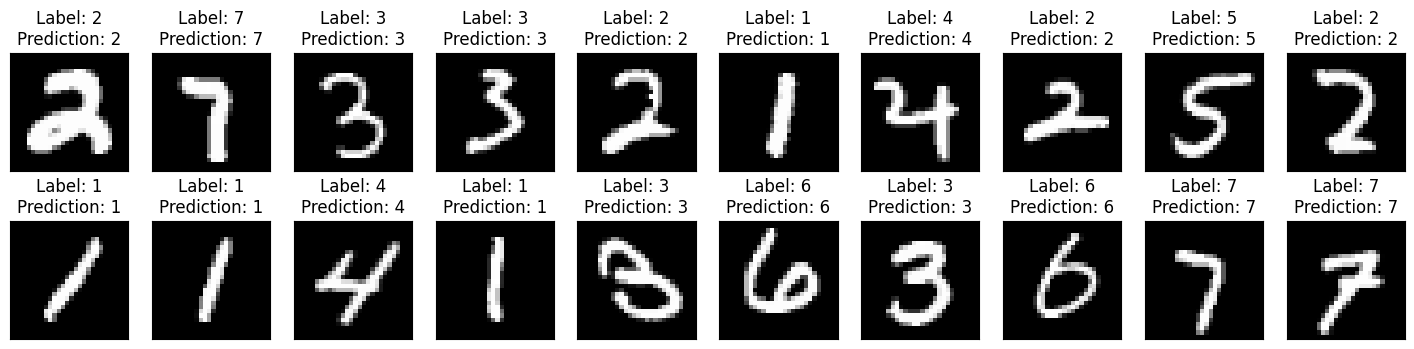

In [75]:
result_visualisation(model, test)